In [1]:
import torch
import sys
import folium
import matplotlib.pyplot as plt
sys.path.append('../')

from models.model_utils import AttrDict, load_rid_freqs, get_rid_rnfea_dict, load_rn_dict, toseq
from models.transformer import TransformerModel, DecoderMulti, Encoder
from models.multi_train import evaluate, init_weights, train
from common.mbr import MBR
from common.road_network import load_rn_shp
from models.datasets import Dataset, collate_fn

In [2]:
def plot_attention(attention, input_seq, output_seq):
    """
    Plots a heatmap of attention weights.
    
    :param attention: A 2D numpy array of attention weights.
    :param input_seq: List of input tokens.
    :param output_seq: List of output tokens.
    """
    fig, ax = plt.subplots()
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_seq, rotation=90)
    ax.set_yticklabels([''] + output_seq)

    # Show label at every tick
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))
    plt.savefig('attention.png')
    plt.show()

In [3]:
args = AttrDict()
device = torch.device('cuda')
args_dict = {'pcm': True, 'module_type': 'test', 'debug': False, 'device': device, 'load_pretrained_flag': False, 'model_old_path': '', 'train_flag': True, 'test_flag': False, 'attn_flag': True, 'dis_prob_mask_flag': False, 'search_dist': 50, 'beta': 15, 'tandem_fea_flag': False, 'pro_features_flag': False, 'online_features_flag': False, 'rid_fea_dim': 8, 'pro_input_dim': 25, 'pro_output_dim': 8, 'poi_num': 5, 'online_dim': 10, 'poi_type': 'company,food,shopping,viewpoint,house', 'min_lat': 41.149, 'min_lng': -8.634, 'max_lat': 41.154, 'max_lng': -8.629, 'keep_ratio': 0.25, 'grid_size': 50, 'time_span': 15, 'win_size': 25, 'ds_type': 'random', 'split_flag': False, 'shuffle': True, 'hid_dim': 512, 'id_emb_dim': 128, 'dropout': 0.4, 'id_size': 781, 'lambda1': 10, 'n_epochs': 50, 'batch_size': 32, 'learning_rate': 0.0001, 'tf_ratio': 0.5, 'clip': 1, 'log_step': 1, 'nhead': 4, 'nlayers': 1, 'max_xid': 12, 'max_yid': 9}
args.update(args_dict)

In [4]:
test_trajs_dir = "../data/model_data/test_data/"
rn_dir = "../data/map/road_network/"
extra_info_dir = "../data/map/extra_info/"

new2raw_rid_dict = load_rid_freqs(extra_info_dir, file_name='new2raw_rid.json')
raw2new_rid_dict = load_rid_freqs(extra_info_dir, file_name='raw2new_rid.json')
rn_dict = load_rn_dict(extra_info_dir, file_name='rn_dict.json')
rid_features_dict = get_rid_rnfea_dict(rn_dict, args)
rn = load_rn_shp(rn_dir, is_directed=True)
mbr = MBR(args.min_lat, args.min_lng, args.max_lat, args.max_lng)
test_dataset = Dataset(
    test_trajs_dir,
    mbr,
    None,
    None,
    None,
    rn,
    new2raw_rid_dict,
    parameters=args,
    is_test=True,
    debug=False
)

# of nodes:444
# of edges:780


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 397.32it/s]


In [5]:
enc = Encoder(args)
dec = DecoderMulti(args)
model = TransformerModel(enc, dec, args, rn, new2raw_rid_dict, raw2new_rid_dict).to(device)
model.apply(init_weights)

TransformerModel(
  (pos_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): CustomTransformerEncoder(
    (layers): ModuleList(
      (0): CustomEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (activation): ReLU()
      )
    )
  )
  (transformer_decoder): CustomTransformerDecoder(
    (layers): ModuleList(
      (0): CustomDecoderLayer(
        (self_attn): CustomMultiheadAttenti

In [6]:
model_path = '../results/test0.25_gs_50_lam_10_attn_True_prob_False_fea_False_20240604_145416/'
model.load_state_dict(torch.load(model_path + 'val-best-model.pt', map_location=device))
# model.load_state_dict(torch.load(model_path + 'train-mid-model.pt'))

<All keys matched successfully>

In [7]:
print('test dataset shape: ' + str(len(test_dataset)))
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
    shuffle=False, collate_fn=collate_fn,
    num_workers=4, pin_memory=True)

test dataset shape: 7647


In [8]:
for i, batch in enumerate(test_iterator):
#     if i<5:
#         continue
    src_grid_seqs, src_gps_seqs, src_pro_feas, src_lengths, trg_gps_seqs, trg_rids, trg_rates, trg_lengths = batch
    src_pro_feas = src_pro_feas.float().to(device)
    max_trg_len = max(trg_lengths)
    batch_size = src_grid_seqs.size(0)
    constraint_mat = torch.zeros(max_trg_len, batch_size, args.id_size).to(device)
    pre_grids = torch.zeros(max_trg_len, batch_size, 3).to(device)
    next_grids = torch.zeros(max_trg_len, batch_size, 3).to(device)
    src_grid_seqs = src_grid_seqs.permute(1, 0, 2).to(device)
    trg_gps_seqs = trg_gps_seqs.permute(1, 0, 2).to(device)
    trg_rids = trg_rids.permute(1, 0, 2).long().to(device)
    trg_rates = trg_rates.permute(1, 0, 2).to(device)
    break

In [ ]:
src_grid_seqs.shape

In [10]:
output_ids, output_rates, attention_weights = model(src_grid_seqs, src_lengths, trg_rids, trg_rates, trg_lengths,
     pre_grids, next_grids, constraint_mat,
     src_pro_feas, None, rid_features_dict,
     teacher_forcing_ratio=0)

output_rates = output_rates.squeeze(2)
output_seqs = toseq(rn_dict, output_ids, output_rates, args)
output_seqs = output_seqs.permute(1,0,2)
trg_gps_seqs = trg_gps_seqs.permute(1,0,2)

In [11]:
gt = trg_gps_seqs[:,1:]
pred = output_seqs[:,1:]
ls = src_gps_seqs[:,1:]

In [53]:
traj_index = 8
m = folium.Map(location=gt[traj_index][0], zoom_start=12)
for point in gt[traj_index].tolist():
    folium.Marker(point).add_to(m)
    
m

In [54]:
m = folium.Map(location=pred[traj_index][0], zoom_start=12)
for point in pred[traj_index].tolist():
    folium.Marker(point).add_to(m)
    
m

In [55]:
m = folium.Map(location=ls[traj_index][0], zoom_start=12)
for point in ls[traj_index].tolist():
    folium.Marker(point).add_to(m)
m

In [56]:
max(trg_lengths),max(src_lengths)

(10, 4)

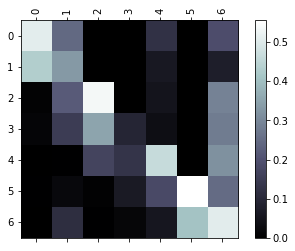

In [65]:
# plot_attention(attention_weights[1][-1][traj_index].cpu().detach().numpy(), list(range(max(trg_lengths))), list(range(max(trg_lengths))))
plot_attention(attention_weights[1][-1][traj_index].cpu().detach().numpy()[:7,:7], list(range(7)),list(range(7)))

In [58]:
attention_weights[0][-1][traj_index].shape

torch.Size([4, 4])

In [59]:
src_grid_seqs[:,traj_index,:]

tensor([[0., 0., 0.],
        [3., 7., 1.],
        [5., 9., 4.],
        [5., 9., 6.]], device='cuda:0')

In [64]:
attention_weights[1][-1][traj_index].cpu().detach().numpy().shape

(10, 10)